<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Cake_eating_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install interpolation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from interpolation import interp
from scipy.optimize import minimize_scalar, bisect
from numba import jit, njit

## Method 1: Value Function Iteration

In [3]:
class CakeEating:
  def __init__(self, gamma, beta, x_0, x_low=1e-3, num_grids=50):
    self.gamma = gamma
    self.beta = beta
    self.x_grids = np.linspace(x_low, x_0, num_grids)

  def utility(self, c):
    gamma = self.gamma
    return c**(1-gamma)/(1-gamma) if self.gamma != 1 else np.log(c)

  def utility_prime(self, c):
    return c**(-self.gamma) if self.gamma != 1 else 1/c

  def value_fun(self, v, x):
    return interp(self.x_grids, v, x)

  def find_best_c(self, v, x):
    fun_c = lambda c: -(self.utility(c) + self.beta*self.value_fun(v, x-c))
    res = minimize_scalar(fun_c, bounds=(0, x), method='Bounded')
    return res.x, -res.fun
  
  def T(self, v):
    Tv = np.empty_like(v)
    for i, x in enumerate(self.x_grids):
      _, new_v = self.find_best_c(v, x)
      Tv[i] = new_v
    return Tv
  
  def fit(self, max_iter=500, tol=1e-5, verbose=True):
    v = np.ones_like(self.x_grids)
    i = 1
    err = tol + 1
    while i < max_iter and err > tol:
      Tv = self.T(v)
      err = np.max(np.abs(Tv - v))

      if err >= tol:
        v[:] = Tv
      i += 1

      if verbose and i%25 == 0:
        print(f'Error is {err} at iteration {i}')

    if i == max_iter:
      raise ValueError('Iteration failed!')

    if verbose:
      print(f'\nConverged on iteration {i}.')

    return v

  def OptimalPolicy(self, v):
    policy = np.empty_like(self.x_grids)
    for i, x in enumerate(self.x_grids):
      c, _ = self.find_best_c(v, x)
      policy[i] = c
    return policy

In [4]:
ce = CakeEating(gamma=1.5, beta=0.96, x_0=2.5, num_grids=120)
v = ce.fit()
policy = ce.OptimalPolicy(v)

Error is 24.807700055284045 at iteration 25
Error is 8.94061365272296 at iteration 50
Error is 3.222167807137339 at iteration 75
Error is 1.1612586988578641 at iteration 100
Error is 0.41851382249114977 at iteration 125
Error is 0.1508310075855661 at iteration 150
Error is 0.05435899993426574 at iteration 175
Error is 0.01959080510800959 at iteration 200
Error is 0.007060461841547294 at iteration 225
Error is 0.002544567267364073 at iteration 250
Error is 0.0009170536892497694 at iteration 275
Error is 0.0003305031389118085 at iteration 300
Error is 0.00011911224635241524 at iteration 325
Error is 4.292766266189574e-05 at iteration 350
Error is 1.547098889886911e-05 at iteration 375

Converged on iteration 386.


In [5]:
def c_star(x, beta=ce.beta, gamma=ce.gamma):
    return (1 - beta ** (1/gamma)) * x


def v_star(x, beta=ce.beta, gamma=ce.gamma):

    return (1 - beta**(1 / gamma))**(-gamma) * (x**(1-gamma) / (1-gamma))

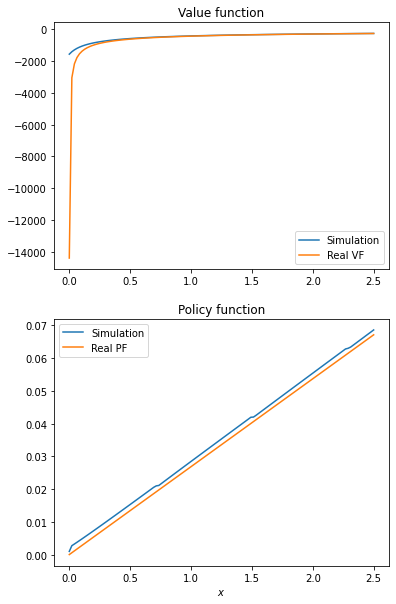

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for vals, ax, title in zip([v, policy], axes.flatten(), ['Value function', 'Policy function']):
  ax.plot(ce.x_grids, vals, label='Simulation')
  ax.set(title=title)
axes[0].plot(ce.x_grids, v_star(ce.x_grids), label='Real VF')
axes[1].plot(ce.x_grids, c_star(ce.x_grids), label='Real PF')
axes[1].set(xlabel='$x$')
axes[0].legend()
axes[1].legend();

## Method 2: Time Iteration

In [7]:
def compute_time_iteration(ce, max_iter=500, verbose=True, tol=1e-5):
  x_grids, u_prime, beta = ce.x_grids, ce.utility_prime, ce.beta

  def policy(sigmas, x):
    return interp(x_grids, sigmas, x)
  
  def find_root(sigmas, x):
    fun_c = lambda c: u_prime(c) - beta*u_prime(policy(sigmas, x-c))
    if x < 1e-12:
      c = 0
    else:
      c = bisect(fun_c, 1e-10, x-1e-10)
    return c
  
  def update_sigmas(sigmas):
    new_sigmas = np.empty_like(sigmas)
    for i, val in enumerate(x_grids):
      new_sigmas[i] = find_root(sigmas, val)
    return new_sigmas
  
  def compute_eq():
    sigmas = np.copy(x_grids)
    err = 1+tol
    i = 0
    while i < max_iter and err > tol:
      Tsigmas = update_sigmas(sigmas)
      i += 1
      err = np.max(np.abs(Tsigmas - sigmas))
    
      if verbose and i%25==0:
        print(f"Error is {err} at iteration {i}.")

      if err > tol:
        sigmas = Tsigmas
      
    if i == max_iter:
      raise ValueError('Iteration failed!')

    if verbose:
      print(f'\nConverged on iteration {i}!')

    return sigmas
  
  return compute_eq()
      

In [8]:
ce = CakeEating(gamma=1.5, beta=0.96, x_0=2.5, num_grids=120, x_low=0)
sigmas = compute_time_iteration(ce)

Error is 0.0036456675931543225 at iteration 25.
Error is 0.0008283185047067848 at iteration 50.
Error is 0.00030791132300957147 at iteration 75.
Error is 0.00013555502390599772 at iteration 100.
Error is 6.417740905302616e-05 at iteration 125.
Error is 3.1438019047758115e-05 at iteration 150.
Error is 1.5658492883291464e-05 at iteration 175.

Converged on iteration 192!


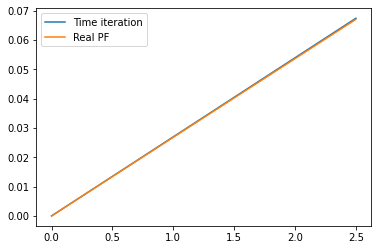

In [9]:
plt.plot(ce.x_grids, sigmas, label='Time iteration')
plt.plot(ce.x_grids, c_star(ce.x_grids), label='Real PF')
plt.legend();

## Exercise 1

In [10]:
class CakeEating2(CakeEating):
  def __init__(self, alpha, gamma, beta, x_0, x_low=1e-3, num_grids=50):
    super().__init__(gamma, beta, x_0, x_low, num_grids)
    self.alpha = alpha

  def find_best_c(self, v, x):
    utility, value_fun, alpha, beta = self.utility, self.value_fun, self.alpha, self.beta
    fun_c = lambda c: -(utility(c) + beta*value_fun(v, (x-c)**alpha))
    res = minimize_scalar(fun_c, bounds=(0, x), method='Bounded')
    return res.x, -res.fun

In [11]:
ce2 = CakeEating2(gamma=1.5, beta=0.96, x_0=2.5, num_grids=120, alpha=0.4)
v = ce2.fit()

Error is 1.400854253641974 at iteration 25
Error is 0.5048632739194403 at iteration 50
Error is 0.18195106638273728 at iteration 75
Error is 0.06557456695351505 at iteration 100
Error is 0.023632858639587084 at iteration 125
Error is 0.0085172046638462 at iteration 150
Error is 0.0030695725979512645 at iteration 175
Error is 0.001106263886597958 at iteration 200
Error is 0.00039869387271096457 at iteration 225
Error is 0.0001436879632876753 at iteration 250
Error is 5.1784670432653e-05 at iteration 275
Error is 1.8663025386445042e-05 at iteration 300

Converged on iteration 316.


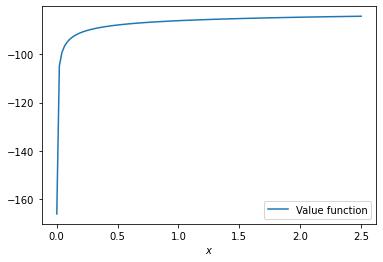

In [12]:
plt.plot(ce2.x_grids, v, label='Value function')
plt.xlabel('$x$')
plt.legend();

In [13]:
policy2 = ce2.OptimalPolicy(v)
ce3 = CakeEating2(gamma=1.5, beta=0.96, x_0=2.5, num_grids=120, alpha=0.99)
v = ce3.fit()
policy3 = ce3.OptimalPolicy(v)

Error is 24.807700055284045 at iteration 25
Error is 8.94061365272296 at iteration 50
Error is 3.222167807137339 at iteration 75
Error is 1.1612586988578641 at iteration 100
Error is 0.41851382249114977 at iteration 125
Error is 0.1508310075855661 at iteration 150
Error is 0.05435899993426574 at iteration 175
Error is 0.01959080510800959 at iteration 200
Error is 0.007060461841547294 at iteration 225
Error is 0.002544567267250386 at iteration 250
Error is 0.0009197057067353853 at iteration 275
Error is 0.0003326430237962086 at iteration 300
Error is 0.00012202238895042683 at iteration 325
Error is 4.470395094813284e-05 at iteration 350
Error is 1.8385580403901258e-05 at iteration 375

Converged on iteration 389.


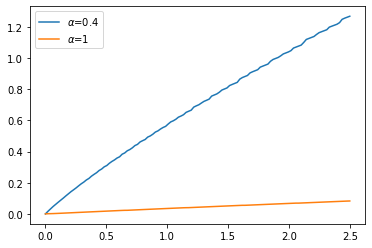

In [14]:
for vals, alpha in zip([policy2, policy3], [0.4, 1]):
  plt.plot(ce3.x_grids, vals, label=fr'$\alpha$={alpha}')
plt.legend();